In [32]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import numpy as np

#Import library code
import helper_code.dataloading as dataloading
import helper_code.model_functions as model_functions
import helper_code.data_vis as data_vis

In [33]:
labels_csv = "camera_data/palomar_observatory_1_data.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

100%|██████████| 1550/1550 [00:00<00:00, 6674.95it/s]


In [34]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [35]:
train['label'].value_counts() / len(train['label'])

label
0    0.506452
1    0.493548
Name: count, dtype: float64

In [36]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="palomar_embeddings_val")

In [37]:
db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

In [38]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [39]:
db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

In [40]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']
img_urls = db_df['img_url']
a_ids = db_df['annotation_id']

In [41]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.148938,0.553821,0.185033,0.293727,-0.972026,0.164165,0.884239,-0.165170,-1.334868,-1.470662,...,1.188147,0.221360,-0.052937,0.054976,-0.356540,0.790986,-1.288528,-0.221503,0.995360,-0.760836
1,0.671764,0.137883,-0.039883,1.044921,-0.455855,-0.532523,0.361776,0.030592,-1.179658,-1.204904,...,0.449065,0.246522,-0.824039,-0.139463,-0.579549,0.530980,-1.295247,-0.603207,0.873842,-1.198020
2,0.623199,-0.087564,-0.552420,1.095964,-0.278021,0.337233,0.475033,0.117867,-0.506564,-1.961951,...,0.854324,0.212768,-0.387216,0.539015,-0.911983,0.421384,-1.099666,-0.231127,0.390191,-1.373861
3,0.891085,0.804647,0.319722,0.160271,-0.343756,-0.369147,0.672537,0.177426,-1.299281,-1.555689,...,1.220661,0.205601,0.245501,0.702328,-0.292161,0.425812,-1.069947,0.083066,0.804128,-1.184821
4,0.469247,-0.229514,-0.233905,1.316242,-0.296501,0.856418,-0.086079,-0.064877,-1.074011,-1.429562,...,1.370185,0.252022,0.090276,0.002863,-0.846975,0.060480,-1.278194,-0.395881,0.826062,-1.671925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.721260,-0.082417,-0.191769,0.959573,-0.123993,0.635294,0.097684,0.110642,-1.146316,-1.448712,...,1.395931,0.239587,0.263703,-0.234283,-0.678583,0.549303,-1.395815,-0.430440,1.260710,-1.556602
306,0.312159,-0.321874,-0.009315,1.371448,-0.451400,0.564181,0.127501,-0.172712,-1.479057,-1.309139,...,1.253966,0.242238,-0.369610,0.074861,-0.838294,0.024428,-1.451027,-0.934063,0.752909,-1.549371
307,0.516762,0.358439,-0.384558,0.295381,-0.333098,0.544617,-0.068301,0.085503,-1.509810,-1.361339,...,1.612252,0.210334,0.297623,0.071363,-0.115116,0.681309,-1.059900,-0.724882,1.006683,-1.181565
308,0.488044,-0.028367,0.039167,1.155285,-0.356130,0.719842,0.449063,0.089883,-1.193412,-1.365252,...,0.909067,0.243671,0.023356,-0.267750,-0.545170,0.179060,-1.180500,-0.486021,0.845874,-1.379328


In [42]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels)


In [43]:
data_vis.save_embeddings_to_json(reduced_embeddings, labels, img_urls, a_ids)

saved embeddings to embedding_data/d3_data.json!


In [44]:
df = pd.DataFrame({
    "x": reduced_embeddings[:,0],
    "y": reduced_embeddings[:,1],
    "label": labels,
    "a_id": val['annotation_id'] 
})

color_map = {0: 'purple', 1: 'gold'}
df['color'] = df['label'].map(color_map)

X = df['x'].values
y = df['label'].values
ids = df['a_id'].values

# find best threshold for desicion stump on x-axis

thresholds = np.unique(X)
best_acc = 0
best_thresh = None
likely_mislabeled = []

for t in thresholds:

    pred1 = (X >= t).astype(int) 
    pred2 = (X < t).astype(int)

    acc1 = (pred1 == y).mean()
    acc2 = (pred2 == y).mean()

    if acc1 > best_acc:
        best_acc = acc1
        best_thresh = t
        likely_mislabeled = ids[pred1 != y]
    if acc2 > best_acc:
        best_acc = acc2
        best_thresh = t
        likley_mislabeled = ids[pred2 != y]

print(f"best threshold: {best_thresh}, accuracy: {best_acc:.3f}")
print("likley mislabeled points:", likley_mislabeled)

best threshold: 0.024222903191770232, accuracy: 0.681
likley mislabeled points: [41915 42504 43680 42370 42417 42384 44153 42392 42424 42464 41703 42538
 42465 44136 43644 43948 42800 43866 42396 43989 42528 43957 43726 43808
 44090 42642 41326 42520 42398 42733 42843 41447 41699 42387 44129 41636
 42572 41248 43639 41818 42598 41671 41741 41148 41865 43886 41155 42739
 41655 42365 44117 42500 41815 43877 43856 43800 41428 41895 41426 44008
 41438 41774 42695 43650 42422 41767 43745 41794 42561 43681 44137 42503
 41143 43781 43715 43736 42446 44135 43834 44119 42660 42690 42359 41863
 41861 43841 43666 42648 44089 41746 41905 43759 42639 41938 44125 42410
 43931 44148 42505]


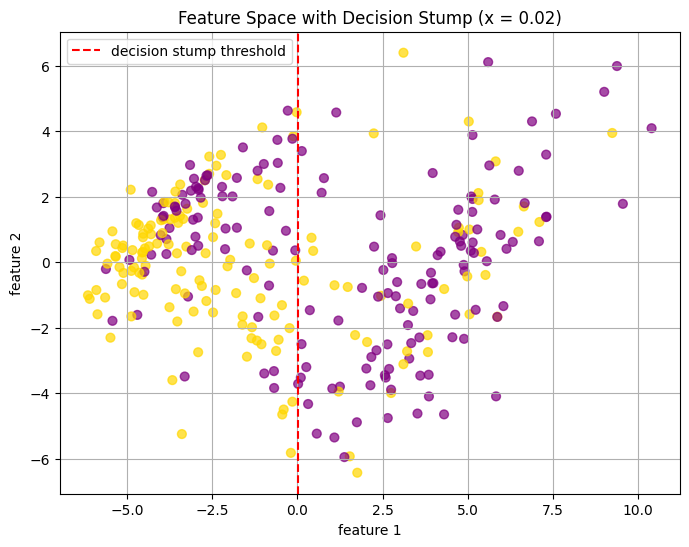

In [45]:
plt.figure(figsize=(8,6))
plt.scatter(df['x'], df['y'], c=df['color'], s=40, alpha=0.7)
plt.axvline(best_thresh, color='red', linestyle='--', label='decision stump threshold')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title(f"Feature Space with Decision Stump (x = {best_thresh:.2f})")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
data_vis.plot_data(reduced_embeddings, labels, pc1=1, pc2=2)
data_vis.format_plot('PCA Reduced Embeddings', 'Principal Component 1', 'Principal Component 2')

TypeError: plot_data() got an unexpected keyword argument 'pc1'

Accuracy: 0.8132911392405063


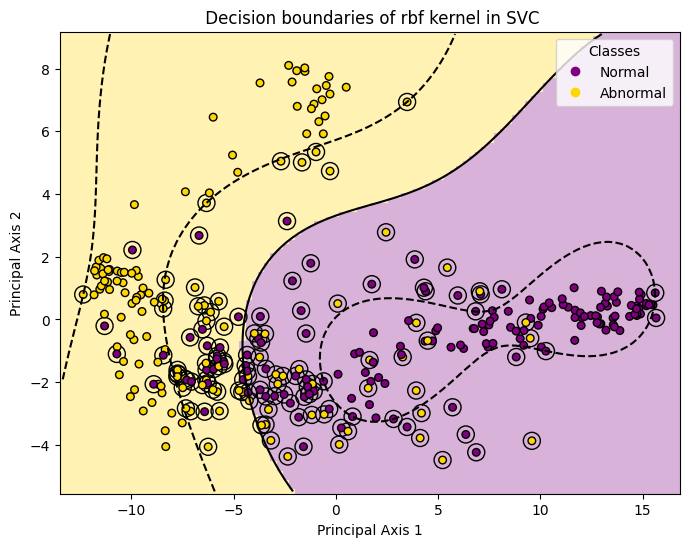

In [ ]:
svm_classifier = data_vis.plot_with_decision_boundary("rbf", reduced_embeddings, labels)

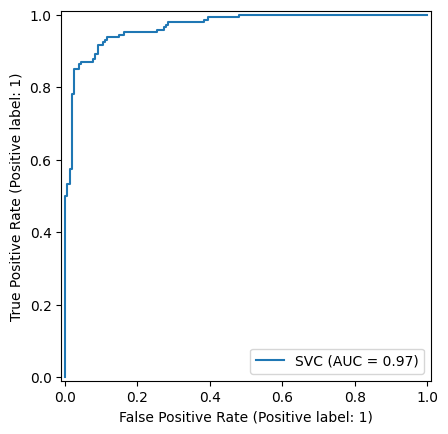

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embeddings, labels)

plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Make sure `embeddings` is a 2D array / DataFrame of shape (n_samples, 768)
X = np.array(embeddings)

pca = PCA(n_components=8, random_state=42)
pcs = pca.fit_transform(X)

pc_cols = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]
pc_df = pd.DataFrame(pcs, columns=pc_cols)

# Attach label + image info so we can color/stratify plots
pc_df = pd.concat(
    [
        pc_df.reset_index(drop=True),
        db_df[['label', 'img_url', 'annotation_id']].reset_index(drop=True)
    ],
    axis=1
)

pc_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,label,img_url,annotation_id
0,-13.378268,1.731211,0.715885,-1.648079,-0.625847,-0.740012,-1.281865,1.116240,1,https://tools.alertcalifornia.org/fireframes5/...,34876
1,-4.369445,1.617009,-4.896039,-3.881187,2.834029,1.010358,1.394504,-2.162386,0,https://tools.alertcalifornia.org/fireframes5/...,31832
2,-0.618749,-5.932678,-1.969395,-0.362175,0.462618,-0.415775,-1.690293,-0.754998,1,https://tools.alertcalifornia.org/fireframes5/...,32994
3,-12.551939,0.626549,1.262945,1.332988,2.500995,2.391900,0.814681,1.913381,1,https://tools.alertcalifornia.org/fireframes5/...,39805
4,-10.326701,-2.079607,-0.312289,2.551321,0.216663,-2.421803,0.226217,-0.296835,1,https://tools.alertcalifornia.org/fireframes5/...,32106


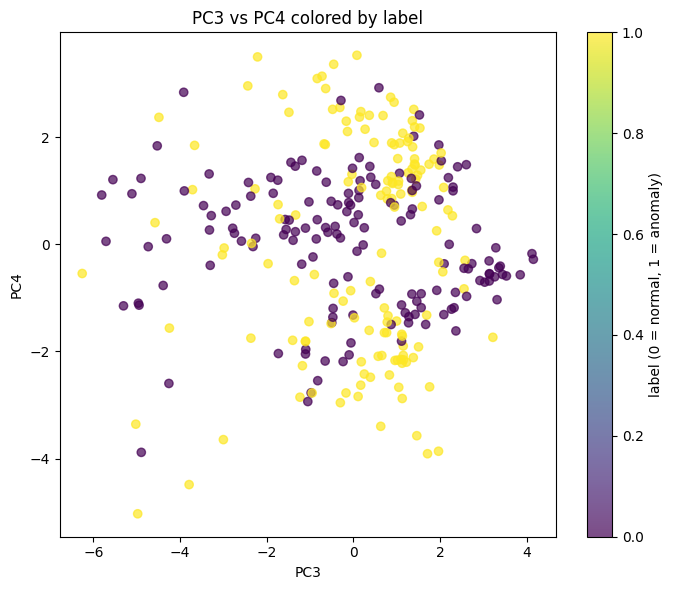

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    pc_df["PC3"],
    pc_df["PC4"],
    c=pc_df["label"],
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="label (0 = normal, 1 = anomaly)")
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title("PC3 vs PC4 colored by label")
plt.tight_layout()
plt.show()


Kept 300 images with valid stats out of 300 sampled.
Correlation of PC3/PC4 with brightness / contrast / hue / saturation:

                 PC3       PC4
brightness -0.449373  0.014033
contrast   -0.416414 -0.163377
hue_mean   -0.488400 -0.062710
sat_mean   -0.462509 -0.105525


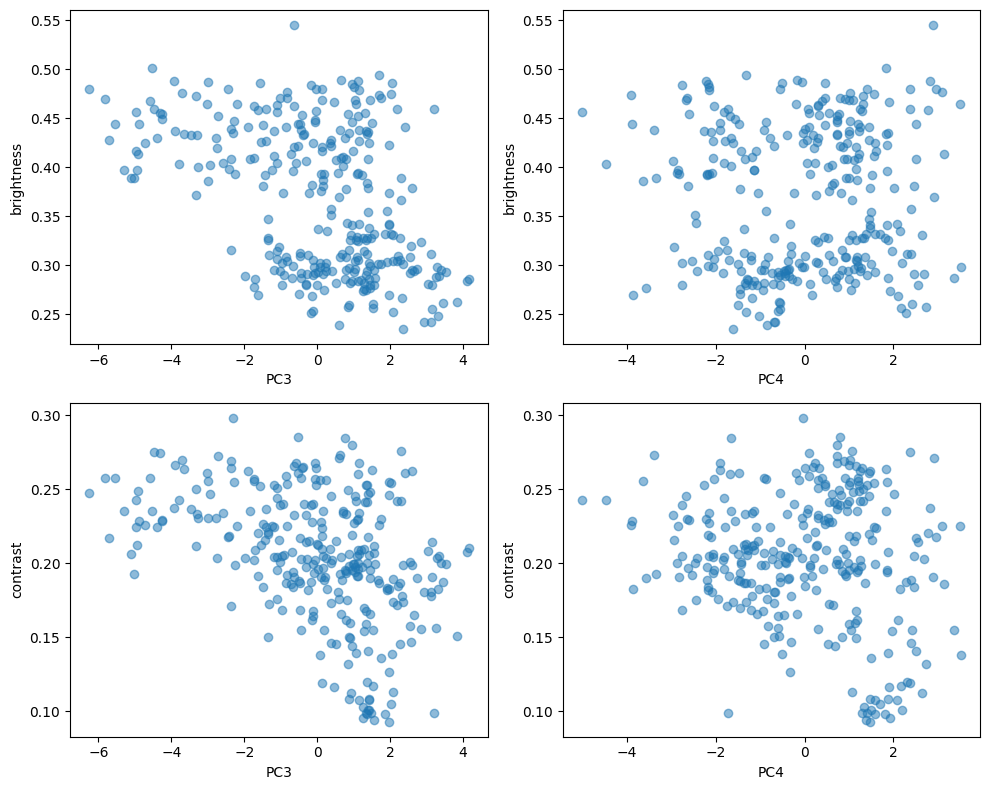

In [ ]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import colors as mpl_colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Work on a subset so you don't hammer the server ----
sample_size = min(400, len(pc_df))   # tweak if you want more/less
sampled = pc_df.sample(n=sample_size, random_state=0).copy()

# ---- 2. Function to compute image stats from URL ----
def compute_img_stats_from_url(url: str):
    try:
        # download image
        resp = requests.get(url, timeout=5)
        resp.raise_for_status()

        img = Image.open(BytesIO(resp.content)).convert("RGB")
        arr = np.asarray(img, dtype=np.float32) / 255.0  # (H, W, 3) in [0,1]

        # basic luminance/contrast
        brightness = float(arr.mean())
        contrast = float(arr.std())

        # hue / saturation from HSV
        flat_rgb = arr.reshape(-1, 3)
        flat_hsv = mpl_colors.rgb_to_hsv(flat_rgb)
        hue_mean = float(flat_hsv[:, 0].mean())
        sat_mean = float(flat_hsv[:, 1].mean())

        return pd.Series(
            {
                "brightness": brightness,
                "contrast": contrast,
                "hue_mean": hue_mean,
                "sat_mean": sat_mean,
            }
        )
    except Exception as e:
        # if anything goes wrong, return NaNs so we can filter later
        return pd.Series(
            {
                "brightness": np.nan,
                "contrast": np.nan,
                "hue_mean": np.nan,
                "sat_mean": np.nan,
            }
        )

# ---- 3. Apply to the sample ----
stats = sampled["img_url"].apply(compute_img_stats_from_url)
sampled = pd.concat([sampled.reset_index(drop=True), stats.reset_index(drop=True)], axis=1)

# Drop rows where download failed
sampled = sampled.dropna(subset=["brightness", "contrast", "hue_mean", "sat_mean"])
print(f"Kept {len(sampled)} images with valid stats out of {sample_size} sampled.")

# ---- 4. Correlation of PC3/PC4 with image features ----
cols = ["PC3", "PC4", "brightness", "contrast", "hue_mean", "sat_mean"]
corr = sampled[cols].corr()

print("Correlation of PC3/PC4 with brightness / contrast / hue / saturation:\n")
print(corr.loc[["brightness", "contrast", "hue_mean", "sat_mean"], ["PC3", "PC4"]])

# ---- 5. Optional: quick visualization ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(sampled["PC3"], sampled["brightness"], alpha=0.5)
axes[0, 0].set_xlabel("PC3")
axes[0, 0].set_ylabel("brightness")

axes[0, 1].scatter(sampled["PC4"], sampled["brightness"], alpha=0.5)
axes[0, 1].set_xlabel("PC4")
axes[0, 1].set_ylabel("brightness")

axes[1, 0].scatter(sampled["PC3"], sampled["contrast"], alpha=0.5)
axes[1, 0].set_xlabel("PC3")
axes[1, 0].set_ylabel("contrast")

axes[1, 1].scatter(sampled["PC4"], sampled["contrast"], alpha=0.5)
axes[1, 1].set_xlabel("PC4")
axes[1, 1].set_ylabel("contrast")

plt.tight_layout()
plt.show()


Principal Component 3 appears to encode global image visibility and clarity.
PC3 shows strong negative correlations with brightness (–0.53), contrast (–0.48), color saturation (–0.52), and hue variation (–0.50). This suggests that PC3 increases when images are darker, less colorful, and lower-contrast, consistent with conditions such as fog, haze, nighttime, rain, or other forms of environmental degradation that reduce camera visibility.

Principal Component 4 shows only weak correlations with these image-level statistics, indicating it captures a more subtle structural or geometric feature of the scene rather than a simple illumination or color-based quality.